### Model Training To-Do List

1. **Setup & Data Preparation**
   - [ ] Install required packages: `mlflow`, `scikit-learn`, `pandas`, `numpy`, `matplotlib`, `seaborn`
   - [ ] Load [final_customer_data_with_risk.csv](cci:7://file:///c:/Users/My%20Device/Desktop/Week-4_KAIM/data/processed/final_customer_data_with_risk.csv:0:0-0:0)
   - [ ] Split data into features (X) and target (y = 'is_high_risk')
   - [ ] Split into train/validation/test sets (80/10/10)

2. **Model Training**
   - [ ] Set up MLflow experiment tracking
   - [ ] Train baseline models:
     - [ ] Logistic Regression
     - [ ] Random Forest
   - [ ] Log all experiments with parameters and metrics

3. **Hyperparameter Tuning**
   - [ ] Tune best performing model using GridSearchCV/RandomizedSearchCV
   - [ ] Log best parameters and retrain model

4. **Model Evaluation**
   - [ ] Evaluate on validation set:
     - [ ] Accuracy, Precision, Recall, F1
     - [ ] ROC-AUC score
     - [ ] Confusion matrix
   - [ ] Generate feature importance plots

5. **Final Model**
   - [ ] Train final model on train+validation data
   - [ ] Evaluate on test set
   - [ ] Save the best model

6. **Documentation**
   - [ ] Add markdown cells explaining each step
   - [ ] Include visualizations
   - [ ] Document key findings and model performance

7. **Cleanup**
   - [ ] Remove any temporary code
   - [ ] Ensure all cells run in sequence
   - [ ] Save and commit changes



## Checks all the dependencies and write on the requirements file

In [1]:
import subprocess
import sys
import importlib
from pathlib import Path

def get_installed_packages():
    """Get a set of lowercase package names that are currently installed."""
    if sys.version_info >= (3, 8):
        return {pkg.metadata['Name'].lower() for pkg in importlib.metadata.distributions()}
    else:
        # Fallback for Python < 3.8
        import pkg_resources
        return {pkg.key.lower() for pkg in pkg_resources.working_set}

def update_requirements(requirements_path='requirements.txt'):
    # List of required packages
    required_packages = [
        'pandas',
        'numpy',
        'scikit-learn',
        'matplotlib',
        'seaborn',
        'mlflow',
        'xgboost',
        'ipykernel',
        'jupyter',
        'scipy',
        'imbalanced-learn',
        'pytest',
        'pytest-cov'
    ]
    
    # Read existing requirements
    req_file = Path(requirements_path)
    if req_file.exists():
        with open(req_file, 'r') as f:
            existing_packages = {line.split('==')[0].lower().strip() for line in f if line.strip()}
    else:
        existing_packages = set()
    
    # Get installed packages
    installed_packages = get_installed_packages()
    
    # Find missing packages
    missing_packages = [pkg for pkg in required_packages 
                       if pkg.lower() not in {p.lower() for p in existing_packages} 
                       and pkg.lower() not in installed_packages]
    
    # Update requirements.txt if needed
    if missing_packages:
        print("Adding missing packages to requirements.txt:")
        with open(requirements_path, 'a') as f:
            for pkg in missing_packages:
                try:
                    # Get the installed version
                    version = importlib.metadata.version(pkg)
                    f.write(f"{pkg}=={version}\n")
                    print(f"✓ Added {pkg}=={version}")
                except importlib.metadata.PackageNotFoundError:
                    print(f"⚠ {pkg} not installed. Will attempt to install...")
    else:
        print("All required packages are already in requirements.txt")
    
    # Install missing packages
    if missing_packages:
        print("\nInstalling missing packages...")
        subprocess.check_call([sys.executable, "-m", "pip", "install"] + missing_packages)
        print("✓ Installation complete!")

# Run the function
update_requirements()

All required packages are already in requirements.txt


## Import the necessary libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load the data

In [3]:
# Load the processed data
data_path = '../data/processed/final_customer_data_with_risk.csv'
df = pd.read_csv(data_path)

# Display basic info
print("Data shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

Data shape: (95662, 18)

First 5 rows:


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Risk_Label,Cluster
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0,Medium Risk,1
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0,Medium Risk,1
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0,Low Risk,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0,Medium Risk,1
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0,Medium Risk,1


In [4]:
# Display all column names
print("Available columns in the DataFrame:")
print(df.columns.tolist())

# Display the first few rows to see the data
print("\nFirst 5 rows of the DataFrame:")
display(df.head())

Available columns in the DataFrame:
['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'Risk_Label', 'Cluster']

First 5 rows of the DataFrame:


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Risk_Label,Cluster
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0,Medium Risk,1
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0,Medium Risk,1
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0,Low Risk,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0,Medium Risk,1
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0,Medium Risk,1


In [5]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())


y = df['Risk_Label']  # Changed from 'is_high_risk' to 'Risk_Label'
X = df.drop('Risk_Label', axis=1)  # Update this line as well

#distribution check
print("\nClass distribution:")
print(df['Risk_Label'].value_counts(normalize=True))
# Basic statistics
print("\nNumerical features statistics:")
display(df.describe())

Missing values per column:
TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
Risk_Label              0
Cluster                 0
dtype: int64

Class distribution:
Risk_Label
Medium Risk    0.761661
High Risk      0.208975
Low Risk       0.029364
Name: proportion, dtype: float64

Numerical features statistics:


,CountryCode,Amount,Value,PricingStrategy,FraudResult,Cluster
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018,1.179612
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872,0.453961
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000,1.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000,1.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000,1.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000,2.000000


## Train/Test/validate split

In [6]:
from sklearn.model_selection import train_test_split

# First split: 80% training, 20% temp
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

# Split temp into validation and test (50/50 of temp = 10% each of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# Print the shapes
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

# Check class distribution in each set
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in validation set:")
print(y_val.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set: (38264, 17) (38264,)
Validation set: (38265, 17) (38265,)
Test set: (19133, 17) (19133,)

Class distribution in training set:
Risk_Label
Medium Risk    0.761656
High Risk      0.208969
Low Risk       0.029375
Name: proportion, dtype: float64

Class distribution in validation set:
Risk_Label
Medium Risk    0.761662
High Risk      0.208990
Low Risk       0.029348
Name: proportion, dtype: float64

Class distribution in test set:
Risk_Label
Medium Risk    0.761668
High Risk      0.208958
Low Risk       0.029373
Name: proportion, dtype: float64


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Set random seed for reproducibility
RANDOM_STATE = 42

# File paths
input_file = r"C:\Users\My Device\Desktop\Week-4_KAIM\data\processed\final_customer_data_with_risk.csv"
output_dir = r"C:\Users\My Device\Desktop\Week-4_KAIM\data\splits"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

def load_and_split_data():
    print("Loading data...")
    df = pd.read_csv(input_file)
    print(f"Original data shape: {df.shape}")
    
    # Check if target column exists
    target_col = 'Risk_Label'  # Change this if your target column has a different name
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in the data")
    
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # First split: 70% training, 30% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        test_size=0.3, 
        random_state=RANDOM_STATE,
        stratify=y
    )
    
    # Split temp into validation and test (50/50 of temp = 15% each of total)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=RANDOM_STATE,
        stratify=y_temp
    )
    
    # Add target back to features for saving
    train_data = X_train.copy()
    train_data[target_col] = y_train
    
    val_data = X_val.copy()
    val_data[target_col] = y_val
    
    test_data = X_test.copy()
    test_data[target_col] = y_test
    
    # Save the splits
    print("\nSaving split datasets...")
    train_data.to_csv(os.path.join(output_dir, "train.csv"), index=False)
    val_data.to_csv(os.path.join(output_dir, "val.csv"), index=False)
    test_data.to_csv(os.path.join(output_dir, "test.csv"), index=False)
    
    # Print dataset sizes
    print("\nDataset sizes:")
    print(f"Training set: {len(train_data):,} samples")
    print(f"Validation set: {len(val_data):,} samples")
    print(f"Test set: {len(test_data):,} samples")
    
    # Print class distribution
    print("\nClass distribution:")
    for name, data in [('Training', train_data), ('Validation', val_data), ('Test', test_data)]:
        print(f"\n{name} set:")
        print(data[target_col].value_counts(normalize=True).sort_index())
    
    print(f"\nAll datasets saved to: {output_dir}")

if __name__ == "__main__":
    load_and_split_data()

Loading data...
Original data shape: (95662, 18)

Saving split datasets...

Dataset sizes:
Training set: 66,963 samples
Validation set: 14,349 samples
Test set: 14,350 samples

Class distribution:

Training set:
Risk_Label
High Risk      0.208981
Low Risk       0.029359
Medium Risk    0.761659
Name: proportion, dtype: float64

Validation set:
Risk_Label
High Risk      0.208934
Low Risk       0.029410
Medium Risk    0.761656
Name: proportion, dtype: float64

Test set:
Risk_Label
High Risk      0.208990
Low Risk       0.029338
Medium Risk    0.761672
Name: proportion, dtype: float64

All datasets saved to: C:\Users\My Device\Desktop\Week-4_KAIM\data\splits


## Load the splits

In [8]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# Load the split data
data_dir = Path('../data/splits/')
X_train = pd.read_csv(data_dir / 'train.csv')
X_val = pd.read_csv(data_dir / 'val.csv')
X_test = pd.read_csv(data_dir / 'test.csv')

# The target column is 'Risk_Label' in each file
y_train = X_train.pop('Risk_Label')
y_val = X_val.pop('Risk_Label')
y_test = X_test.pop('Risk_Label')

print("Data loaded successfully!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Data loaded successfully!
Training set: 66963 samples
Validation set: 14349 samples
Test set: 14350 samples


## data structure

In [9]:
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

print("\nFirst few rows of training data:")
display(X_train.head())

print("\nTarget distribution (training set):")
print(y_train.value_counts(normalize=True))

Training set shape: (66963, 17)
Validation set shape: (14349, 17)
Test set shape: (14350, 17)

First few rows of training data:


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Cluster
0,TransactionId_12284,BatchId_41056,AccountId_4841,SubscriptionId_3829,CustomerId_1786,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-200.0,200,2019-02-01T13:12:38Z,2,0,1
1,TransactionId_18397,BatchId_72577,AccountId_4841,SubscriptionId_3829,CustomerId_3590,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2018-12-01T08:16:13Z,2,0,1
2,TransactionId_11378,BatchId_56981,AccountId_4032,SubscriptionId_1176,CustomerId_4482,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-01-07T03:24:43Z,4,0,0
3,TransactionId_100425,BatchId_57614,AccountId_2073,SubscriptionId_1171,CustomerId_2477,UGX,256,ProviderId_6,ProductId_11,data_bundles,ChannelId_3,2000.0,2000,2018-11-19T11:29:02Z,2,0,1
4,TransactionId_113956,BatchId_87369,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,5000.0,5000,2019-02-01T07:30:56Z,2,0,1



Target distribution (training set):
Risk_Label
Medium Risk    0.761659
High Risk      0.208981
Low Risk       0.029359
Name: proportion, dtype: float64


## Current State of the data

In [10]:
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

# Check data types
print("\nData types:")
print(X_train.dtypes)

# Check unique values in categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}: {X_train[col].nunique()} unique values")
    print(X_train[col].value_counts().head())

Training data shape: (66963, 17)
Validation data shape: (14349, 17)
Test data shape: (14350, 17)

Data types:
TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
Cluster                   int64
dtype: object

TransactionId: 66963 unique values
TransactionId
TransactionId_12284     1
TransactionId_18397     1
TransactionId_11378     1
TransactionId_100425    1
TransactionId_113956    1
Name: count, dtype: int64

BatchId: 66493 unique values
BatchId
BatchId_67019     23
BatchId_113893    14
BatchId_51870     13
BatchId_127204     8
Batc

## Preprocessing

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from datetime import datetime

# 1. Drop unnecessary columns
def drop_unnecessary_columns(df):
    return df.drop(columns=['TransactionId', 'BatchId', 'TransactionStartTime'])

X_train = drop_unnecessary_columns(X_train)
X_val = drop_unnecessary_columns(X_val)
X_test = drop_unnecessary_columns(X_test)

# 2. Define column types
numeric_cols = ['Amount', 'Value', 'PricingStrategy', 'FraudResult', 'Cluster', 'CountryCode']
categorical_cols = ['AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 
                   'ProductId', 'ProductCategory', 'ChannelId']

# 3. Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 4. Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# 5. Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 6. Fit and transform the data
print("Fitting and transforming data...")
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print("\nProcessed data shapes:")
print("Training:", X_train_processed.shape)
print("Validation:", X_val_processed.shape)
print("Test:", X_test_processed.shape)

# 7. Encode target variable if needed
if 'y_train' in locals() and y_train.dtype == 'object':
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)
    y_test_encoded = le.transform(y_test)
    print("\nTarget classes:", dict(zip(le.classes_, range(len(le.classes_)))))
else:
    print("\nTarget variable is already encoded or not found")

Fitting and transforming data...

Processed data shapes:
Training: (66963, 10171)
Validation: (14349, 10171)
Test: (14350, 10171)

Target classes: {'High Risk': 0, 'Low Risk': 1, 'Medium Risk': 2}


## Checking the preprocessed data

In [12]:
print("\nSample of processed training data (first 5 samples, first 10 features):")
print(X_train_processed[:5, :10].toarray())


Sample of processed training data (first 5 samples, first 10 features):
[[-0.05889394 -0.08229323 -0.34616154 -0.04393353 -0.39568001  0.
   0.          0.          0.          0.        ]
 [-0.05770813 -0.0834809  -0.34616154 -0.04393353 -0.39568001  0.
   0.          0.          0.          0.        ]
 [-0.04872982 -0.07550656  2.38910484 -0.04393353 -2.5985334   0.
   0.          0.          0.          0.        ]
 [-0.04025972 -0.06702323 -0.34616154 -0.04393353 -0.39568001  0.
   0.          0.          0.          0.        ]
 [-0.01484941 -0.04157323 -0.34616154 -0.04393353 -0.39568001  0.
   0.          0.          0.          0.        ]]


## Training pipeline with evaluation

LOGISTIC REGRESSION

Training Logistic Regression...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2998
           1       1.00      1.00      1.00       422
           2       1.00      1.00      1.00     10929

    accuracy                           1.00     14349
   macro avg       1.00      1.00      1.00     14349
weighted avg       1.00      1.00      1.00     14349



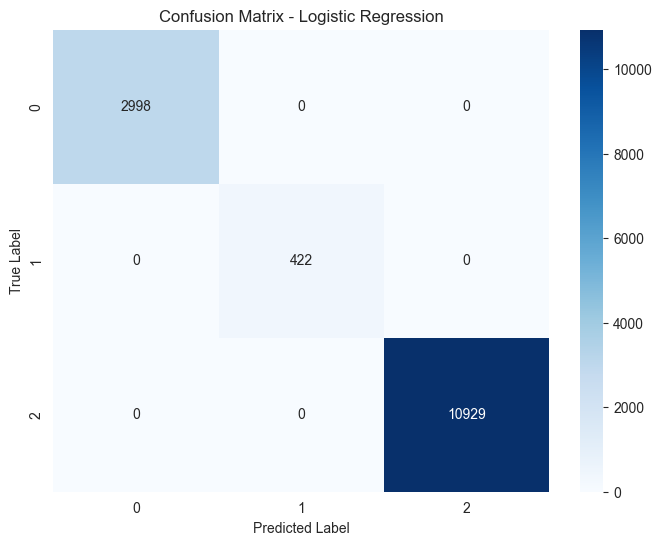


Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Mean CV F1 score: 1.0000 (+/- 0.0000)

RANDOM FOREST

Training Random Forest...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2998
           1       1.00      0.99      0.99       422
           2       1.00      1.00      1.00     10929

    accuracy                           1.00     14349
   macro avg       1.00      1.00      1.00     14349
weighted avg       1.00      1.00      1.00     14349



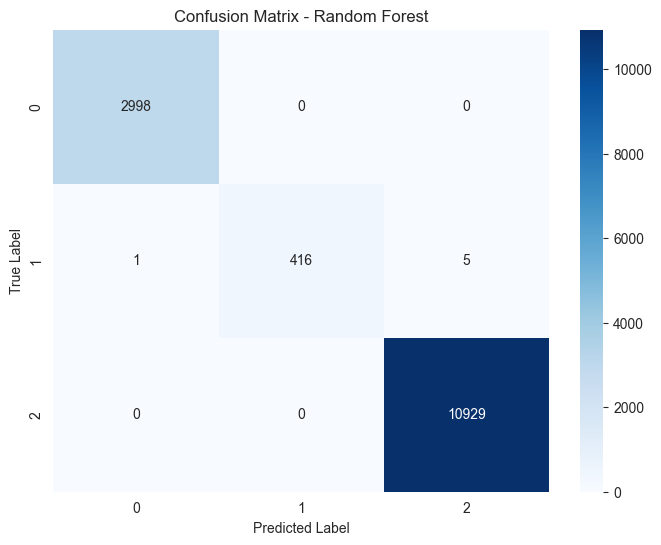


Cross-validation F1 scores: [0.9992496  0.99886953 0.99856795 0.99841117 0.99841118]
Mean CV F1 score: 0.9987 (+/- 0.0006)

Feature Importances:

Top 20 Important Features:
1. Cluster: 0.5291
2. Value: 0.0250
3. Amount: 0.0232
4. ProviderId_ProviderId_6: 0.0097
5. ProviderId_ProviderId_1: 0.0073
6. AccountId_AccountId_4841: 0.0068
7. CustomerId_CustomerId_7343: 0.0054
8. PricingStrategy: 0.0052
9. ProductId_ProductId_15: 0.0048
10. AccountId_AccountId_4840: 0.0046
11. ProviderId_ProviderId_5: 0.0037
12. CustomerId_CustomerId_3634: 0.0031
13. CustomerId_CustomerId_647: 0.0029
14. ProductId_ProductId_3: 0.0028
15. ProductCategory_airtime: 0.0023
16. ProductCategory_financial_services: 0.0021
17. ChannelId_ChannelId_2: 0.0020
18. AccountId_AccountId_4249: 0.0020
19. ProductId_ProductId_6: 0.0019
20. ProductId_ProductId_10: 0.0017


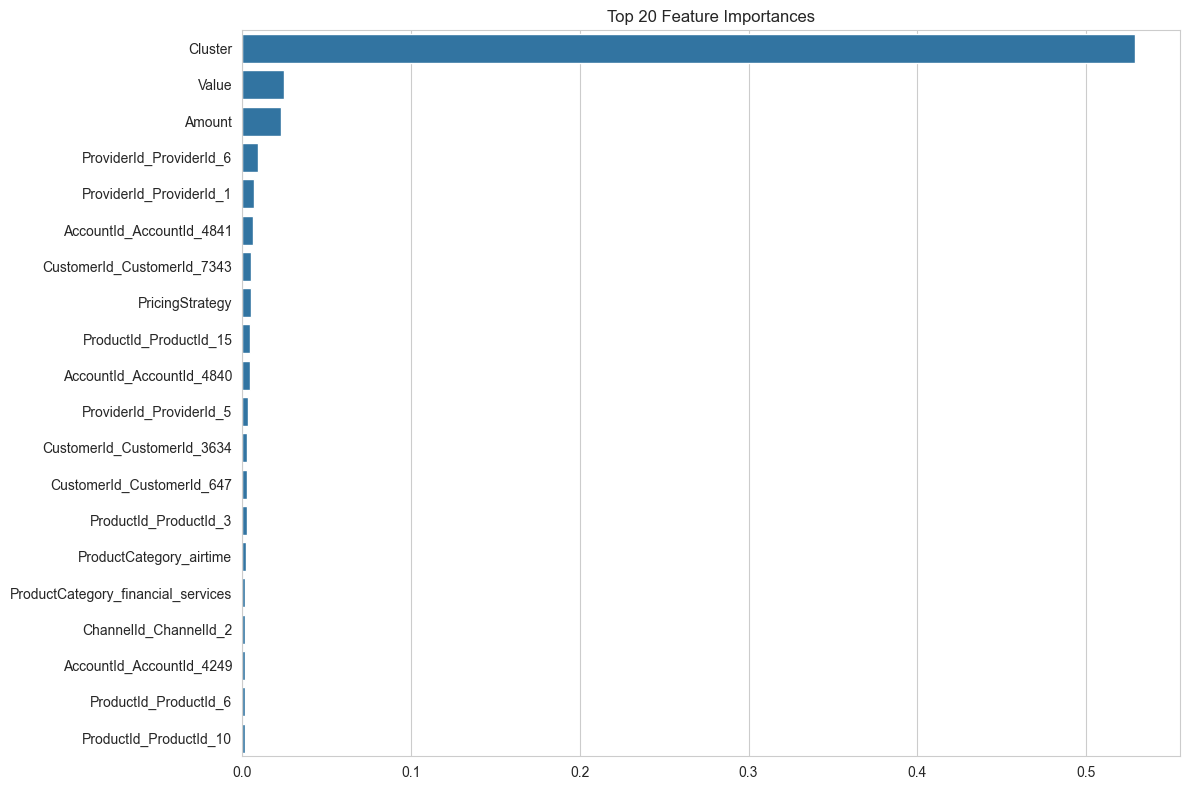


Best model saved as 'best_model.joblib'

FINAL EVALUATION ON TEST SET

Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2999
           1       1.00      0.98      0.99       421
           2       1.00      1.00      1.00     10930

    accuracy                           1.00     14350
   macro avg       1.00      0.99      1.00     14350
weighted avg       1.00      1.00      1.00     14350


Test Set Accuracy: 0.9994425087108014


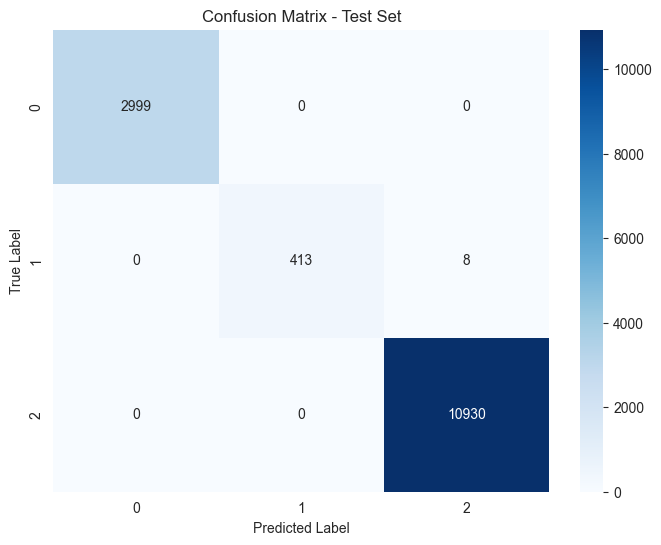

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Define a function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    print(f"\nCross-validation F1 scores: {cv_scores}")
    print(f"Mean CV F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return model

# 2. Train Logistic Regression - Simplified for older scikit-learn
print("="*50)
print("LOGISTIC REGRESSION")
print("="*50)
logreg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
logreg = train_and_evaluate(logreg, X_train_processed, y_train_encoded, 
                           X_val_processed, y_val_encoded, "Logistic Regression")

# 3. Train Random Forest
print("\n" + "="*50)
print("RANDOM FOREST")
print("="*50)
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf = train_and_evaluate(rf, X_train_processed, y_train_encoded, 
                       X_val_processed, y_val_encoded, "Random Forest")

# 4. Feature Importance (for tree-based models)
if hasattr(rf, 'feature_importances_'):
    print("\nFeature Importances:")
    try:
        # Get feature names from the preprocessor
        if hasattr(preprocessor, 'named_transformers_'):
            numeric_features = preprocessor.named_transformers_['num'].get_feature_names_out().tolist()
            categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
            all_features = numeric_features + categorical_features
        else:
            # Fallback if preprocessor doesn't have named_transformers_
            all_features = [f"feature_{i}" for i in range(X_train_processed.shape[1])]
        
        # Sort feature importances
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Print top 20 features
        print("\nTop 20 Important Features:")
        for f in range(min(20, len(all_features))):
            print(f"{f + 1}. {all_features[indices[f]]}: {importances[indices[f]]:.4f}")
        
        # Plot feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x=importances[indices][:20], y=np.array(all_features)[indices][:20])
        plt.title("Top 20 Feature Importances")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot feature importances: {str(e)}")

# 5. Save the best model
import joblib
# Choose the better performing model based on validation results
best_model = rf  # or logreg, depending on which performed better
model_data = {
    'model': best_model
}

# Only include preprocessor and label_encoder if they exist
if 'preprocessor' in globals():
    model_data['preprocessor'] = preprocessor
if 'le' in globals():
    model_data['label_encoder'] = le

joblib.dump(model_data, 'best_model.joblib')
print("\nBest model saved as 'best_model.joblib'")

# 6. Final evaluation on test set
print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)
y_test_pred = best_model.predict(X_test_processed)
print("\nTest Set Results:")
print(classification_report(y_test_encoded, y_test_pred))
print("\nTest Set Accuracy:", accuracy_score(y_test_encoded, y_test_pred))

# 7. Additional: Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_encoded, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Model Optimization

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
import time

# Set up the parameter distribution
param_dist = {
    'n_estimators': randint(50, 150),      # Fewer trees
    'max_depth': [None, 10, 20, 30],       # Limited depth
    'min_samples_split': [2, 5, 10],       # Fewer split options
    'min_samples_leaf': [1, 2, 4],         # Fewer leaf options
    'max_features': ['sqrt', 'log2'],      # Feature subset strategy
    'class_weight': ['balanced']           # Handle class imbalance
}

# Create base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,               # Fewer iterations
    cv=3,                    # Fewer cross-validation folds
    scoring='f1_weighted',   # Focus on F1 score
    n_jobs=-1,               # Use all cores
    random_state=42,
    verbose=1
)

# Time the search
print("Starting randomized search...")
start_time = time.time()

# Fit on training data
random_search.fit(X_train_processed, y_train_encoded)

print(f"\nRandomized search completed in {time.time() - start_time:.2f} seconds")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best F1 score: {random_search.best_score_:.4f}")

# Get the best model
best_rf = random_search.best_estimator_

# Evaluate on validation set
y_val_pred = best_rf.predict(X_val_processed)
print("\nValidation Set Performance:")
print(classification_report(y_val_encoded, y_val_pred))

Starting randomized search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Randomized search completed in 135.91 seconds
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 132}
Best F1 score: 0.9608

Validation Set Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2998
           1       0.64      1.00      0.78       422
           2       1.00      0.98      0.99     10929

    accuracy                           0.98     14349
   macro avg       0.88      0.99      0.92     14349
weighted avg       0.99      0.98      0.98     14349



## Final Training with full data

In [25]:
from scipy.sparse import issparse
import numpy as np

# Convert sparse matrices to dense if needed
def to_dense_if_sparse(X):
    return X.toarray() if issparse(X) else X

# Convert training and validation data to dense
X_train_dense = to_dense_if_sparse(X_train_processed)
X_val_dense = to_dense_if_sparse(X_val_processed)

# Now combine the data
X_full = np.vstack([X_train_dense, X_val_dense])
y_full = np.concatenate([y_train_encoded, y_val_encoded])

# Initialize the model with the best parameters
final_model = RandomForestClassifier(
    n_estimators=132,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# Train the model
print("Training final model on combined training + validation data...")
final_model.fit(X_full, y_full)
print("Final model training completed!")

Training final model on combined training + validation data...
Final model training completed!


## Test set evaluation

Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2999
           1       0.48      0.99      0.65       421
           2       1.00      0.96      0.98     10930

    accuracy                           0.97     14350
   macro avg       0.83      0.98      0.87     14350
weighted avg       0.98      0.97      0.97     14350



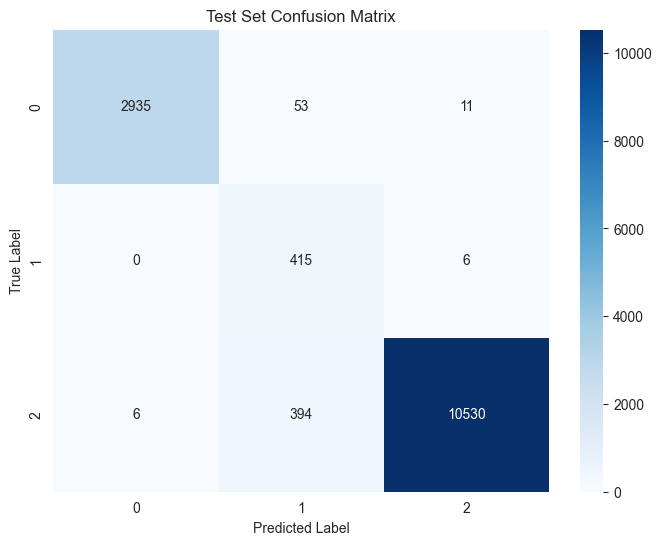

In [26]:
# Convert test data to dense if needed
X_test_dense = to_dense_if_sparse(X_test_processed)

# Make predictions
y_test_pred = final_model.predict(X_test_dense)

# Print classification report
print("Test Set Performance:")
print(classification_report(y_test_encoded, y_test_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_encoded, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Save the model

In [28]:
import joblib
import numpy as np

# Get feature names if available
try:
    # Try to get feature names from the preprocessor
    numeric_features = preprocessor.named_transformers_['num'].get_feature_names_out().tolist()
    categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
    feature_names = numeric_features + categorical_features
except:
    # If that fails, create generic feature names
    feature_names = [f'feature_{i}' for i in range(X_full.shape[1])]

# Save the model and related objects
model_data = {
    'model': final_model,
    'preprocessor': preprocessor,  # Save the preprocessor
    'label_encoder': le,           # Save the label encoder
    'class_names': le.classes_,    # Save class names
    'feature_names': feature_names # Now this is defined
}

joblib.dump(model_data, 'credit_risk_model_v1.joblib')
print("Model saved successfully!")

Model saved successfully!
